# Clustering

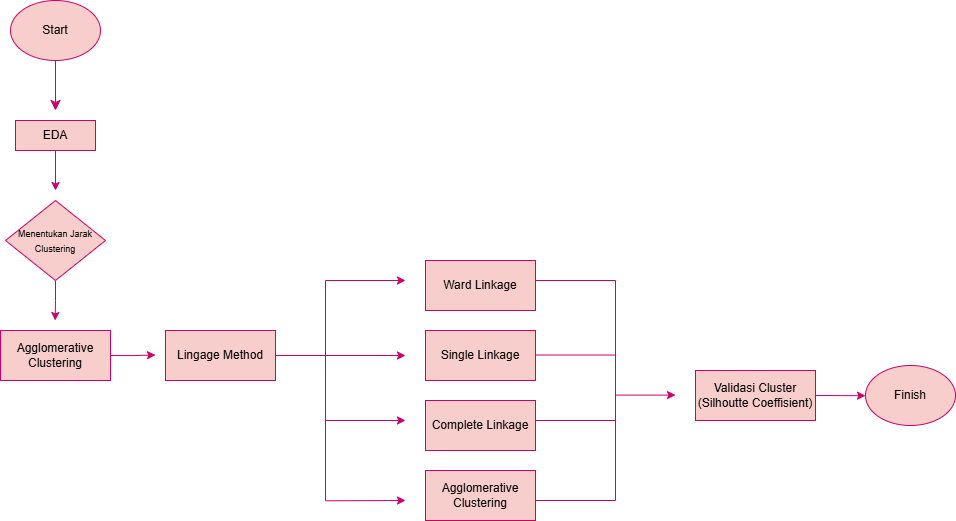

## Import Libraries

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Import Datasets

Dataset yang digunakan berjudul “insurance customer.csv”, yang berisi data pelanggan asuransi dengan berbagai atribut seperti usia (Age), premi tahunan (Annual_Premium), dan saluran penjualan (Policy_Sales_Channel).
Perintah customer.info() menampilkan jumlah kolom, tipe data, dan jumlah nilai non-null, sedangkan customer.head() menampilkan beberapa baris awal data untuk memastikan file berhasil dibaca dengan benar.

In [161]:
import os

from google.colab import drive
drive.mount('/content/gdrive')
customer = pd.read_csv("/content/gdrive/My Drive/data asuransi.csv")
customer.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1000 non-null   int64 
 1   Gender                1000 non-null   object
 2   Age                   1000 non-null   int64 
 3   Driving_License       1000 non-null   int64 
 4   Region_Code           1000 non-null   int64 
 5   Previously_Insured    1000 non-null   int64 
 6   Vehicle_Age           1000 non-null   object
 7   Vehicle_Damage        1000 non-null   object
 8   Annual_Premium        1000 non-null   int64 
 9   Policy_Sales_Channel  1000 non-null   int64 
 10  Vintage               1000 non-null   int64 
 11  Response              1000 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 93.9+ KB


#Cek Missing Value dan Duplikasi

In [162]:
# cuplikan data customer
customer.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,100000,Male,22,1,8,0,< 1 Year,Yes,36513,160,189,0
1,100001,Male,24,1,36,0,< 1 Year,Yes,2630,160,268,0
2,100002,Female,22,1,15,0,< 1 Year,Yes,35832,152,289,0
3,100003,Male,72,1,28,0,> 2 Years,Yes,36685,26,113,0
4,100004,Male,66,1,28,0,> 2 Years,Yes,2630,45,123,1


Langkah ini digunakan untuk memastikan data bersih sebelum dianalisis.
customer.isna().sum() memeriksa apakah ada nilai kosong (missing value), sedangkan customer.duplicated().sum() memeriksa apakah ada baris data yang terduplikasi.

In [163]:
# checck missing value
customer.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [164]:
customer.duplicated().sum()

np.int64(0)

Hasilnya menunjukkan tidak ada missing value maupun data duplikat, artinya dataset sudah bersih dan siap digunakan.

In [165]:
# drop kolom ID karena tidak bermakna
cols_to_drop = ["Gender", "Vehicle_Age", "Vehicle_Damage", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage" "Response" ]

customer = customer.drop(columns=[c for c in cols_to_drop if c in customer.columns])

In [166]:
customer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    1000 non-null   int64
 1   Age                   1000 non-null   int64
 2   Annual_Premium        1000 non-null   int64
 3   Policy_Sales_Channel  1000 non-null   int64
 4   Vintage               1000 non-null   int64
 5   Response              1000 non-null   int64
dtypes: int64(6)
memory usage: 47.0 KB


#Statistik Deskriptif dan Skala Fitur

Tujuannya adalah untuk melihat ringkasan data seperti nilai minimum, maksimum, rata-rata (mean), dan standar deviasi dari setiap kolom numerik pada dataset pelanggan asuransi.



In [167]:
# deskripsi statistik
customer.describe()

,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,100499.500000,39.653000,30364.102000,108.303000,154.565000,0.123000
std,288.819436,15.776929,16348.152121,55.577442,83.320815,0.328602
min,100000.000000,20.000000,2630.000000,1.000000,10.000000,0.000000
25%,100249.750000,25.000000,24415.250000,26.000000,88.000000,0.000000
50%,100499.500000,38.000000,31511.500000,124.000000,154.000000,0.000000
75%,100749.250000,50.250000,39555.750000,152.000000,227.000000,0.000000
max,100999.000000,85.000000,100278.000000,163.000000,299.000000,1.000000


Dari hasilnya, kita bisa lihat kalau setiap fitur punya skala nilai yang berbeda-beda.
Dari hasilnya terlihat bahwa setiap variabel memiliki rentang nilai yang berbeda jauh, misalnya kolom Age bernilai puluhan sementara Annual_Premium bernilai ratusan ribu

Perbedaan skala ini berpotensi menyebabkan fitur tertentu mendominasi proses perhitungan jarak, sehingga perlu dilakukan normalisasi atau scaling.

#Normalisasi Data (Min-Max Scaling)

Di tahap ini dilakukan normalisasi menggunakan MinMaxScaler agar semua fitur berada dalam rentang 0 sampai 1.
Hal ini penting dalam algoritma berbasis jarak seperti Agglomerative Clustering, karena perbedaan skala dapat mempengaruhi hasil pengelompokan.

In [168]:
# minmax scaler sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
customer_scaled = scaler.fit_transform(customer)

pd.DataFrame(customer_scaled).describe()

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.500000,0.302354,0.284021,0.662364,0.500225,0.123000
std,0.289109,0.242722,0.167419,0.343071,0.288307,0.328602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.076923,0.223100,0.154321,0.269896,0.000000
50%,0.500000,0.276923,0.295772,0.759259,0.498270,0.000000
75%,0.750000,0.465385,0.378152,0.932099,0.750865,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Setelah proses scaling, semua fitur menjadi setara, sehingga setiap variabel berkontribusi seimbang terhadap pembentukan cluster.

#Agglomerative Clustering

#Visualisasi Matriks Korelasi

Matriks korelasi digunakan untuk melihat hubungan awal antarvariabel sebelum dilakukan proses clustering.


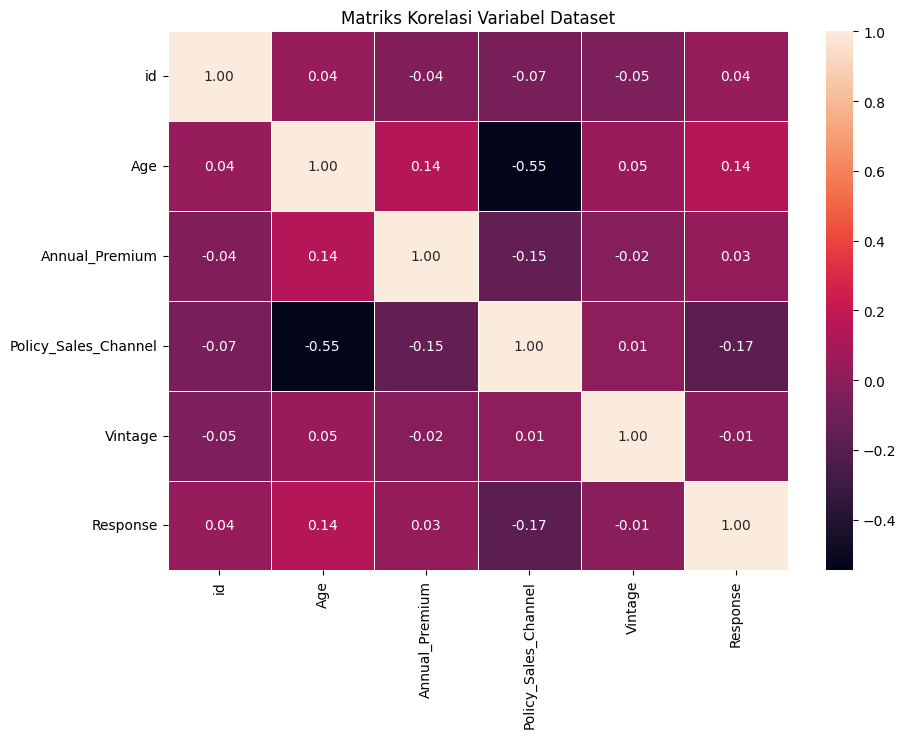

In [169]:

# 1. Copy dataframe agar tidak mengubah data asli
df_corr = customer.copy()

# 2. Encode kolom object menjadi angka (Vehicle_Age & Vehicle_Damage)
for col in df_corr.select_dtypes(include=['object']).columns:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# 3. Hitung korelasi
corr_matrix = df_corr.corr()

# 4. Plot heatmap korelasi
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title("Matriks Korelasi Variabel Dataset")
plt.show()

#Jarak Clustering

In [170]:
from scipy.spatial.distance import pdist, squareform

# 1. Jarak Euclidean
dist_euclidean = squareform(pdist(customer_scaled, metric='euclidean'))
df_euclidean = pd.DataFrame(dist_euclidean)

# 2. Jarak Manhattan
dist_manhattan = squareform(pdist(customer_scaled, metric='cityblock'))
df_manhattan = pd.DataFrame(dist_manhattan)

# 3. Jarak Canberra
dist_canberra = squareform(pdist(customer_scaled, metric='canberra'))
df_canberra = pd.DataFrame(dist_canberra)

# Tampilkan hasil
print("Jarak Euclidean:\n", df_euclidean)
print("\nJarak Manhattan:\n", df_manhattan)
print("\nJarak Canberra:\n", df_canberra)

Jarak Euclidean:
           0         1         2         3         4         5         6    \
0    0.000000  0.442803  0.349602  1.159775  1.461069  1.367618  0.349189   
1    0.442803  0.000000  0.352531  1.280158  1.474172  1.359133  0.281944   
2    0.349602  0.352531  0.000000  1.252042  1.529713  1.305448  0.076867   
3    1.159775  1.280158  1.252042  0.000000  1.070095  1.237080  1.230749   
4    1.461069  1.474172  1.529713  1.070095  0.000000  0.715872  1.498343   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.082075  1.098815  1.085293  1.384523  1.650965  1.616909  1.067208   
996  1.401577  1.484669  1.415104  1.063010  1.512139  1.465160  1.406300   
997  1.012659  1.042453  1.018421  1.536091  1.759285  1.646010  1.010551   
998  1.115823  1.175164  1.105817  1.300697  1.629369  1.548619  1.098072   
999  1.016612  1.125005  1.073881  1.442056  1.717503  1.663857  1.069474   

          7         8         9    ...       990       99

#Visualisasi hasil cluster

##WARD

In [172]:
# --- WARD ---
from sklearn.cluster import AgglomerativeClustering

agg_clus_ward = AgglomerativeClustering(
    n_clusters=5,
    linkage="ward"
)
agg_clus_ward.fit(customer_scaled)

# assign label
customer["label_ward"] = agg_clus_ward.labels_
customer.head()

,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,label_ward
0,100000,22,36513,160,189,0,4
1,100001,24,2630,160,268,0,4
2,100002,22,35832,152,289,0,4
3,100003,72,36685,26,113,0,2
4,100004,66,2630,45,123,1,0


##SINGLE

In [173]:
# --- SINGLE ---
from sklearn.cluster import AgglomerativeClustering

agg_clus_single = AgglomerativeClustering(
    n_clusters=5,
    linkage="single"
)
agg_clus_single.fit(customer_scaled)

# assign label
customer["label_single"] = agg_clus_single.labels_
customer.head()


,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,label_ward,label_single
0,100000,22,36513,160,189,0,4,1
1,100001,24,2630,160,268,0,4,1
2,100002,22,35832,152,289,0,4,1
3,100003,72,36685,26,113,0,2,1
4,100004,66,2630,45,123,1,0,4


##AVERAGE

In [174]:
# --- AVERAGE ---
from sklearn.cluster import AgglomerativeClustering

agg_clus_average = AgglomerativeClustering(
    n_clusters=5,
    linkage="average"
)
agg_clus_average.fit(customer_scaled)

# assign label
customer["label_average"] = agg_clus_average.labels_
customer.head()


,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,label_ward,label_single,label_average
0,100000,22,36513,160,189,0,4,1,2
1,100001,24,2630,160,268,0,4,1,2
2,100002,22,35832,152,289,0,4,1,2
3,100003,72,36685,26,113,0,2,1,0
4,100004,66,2630,45,123,1,0,4,3


##COMPLETE

In [175]:
# --- COMPLETE ---
from sklearn.cluster import AgglomerativeClustering

agg_clus_complete = AgglomerativeClustering(
    n_clusters=5,
    linkage="complete"
)
agg_clus_complete.fit(customer_scaled)

# assign label
customer["label_complete"] = agg_clus_complete.labels_
customer.head()


,id,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,label_ward,label_single,label_average,label_complete
0,100000,22,36513,160,189,0,4,1,2,4
1,100001,24,2630,160,268,0,4,1,2,4
2,100002,22,35832,152,289,0,4,1,2,4
3,100003,72,36685,26,113,0,2,1,0,2
4,100004,66,2630,45,123,1,0,4,3,0


#DENDOGRAM

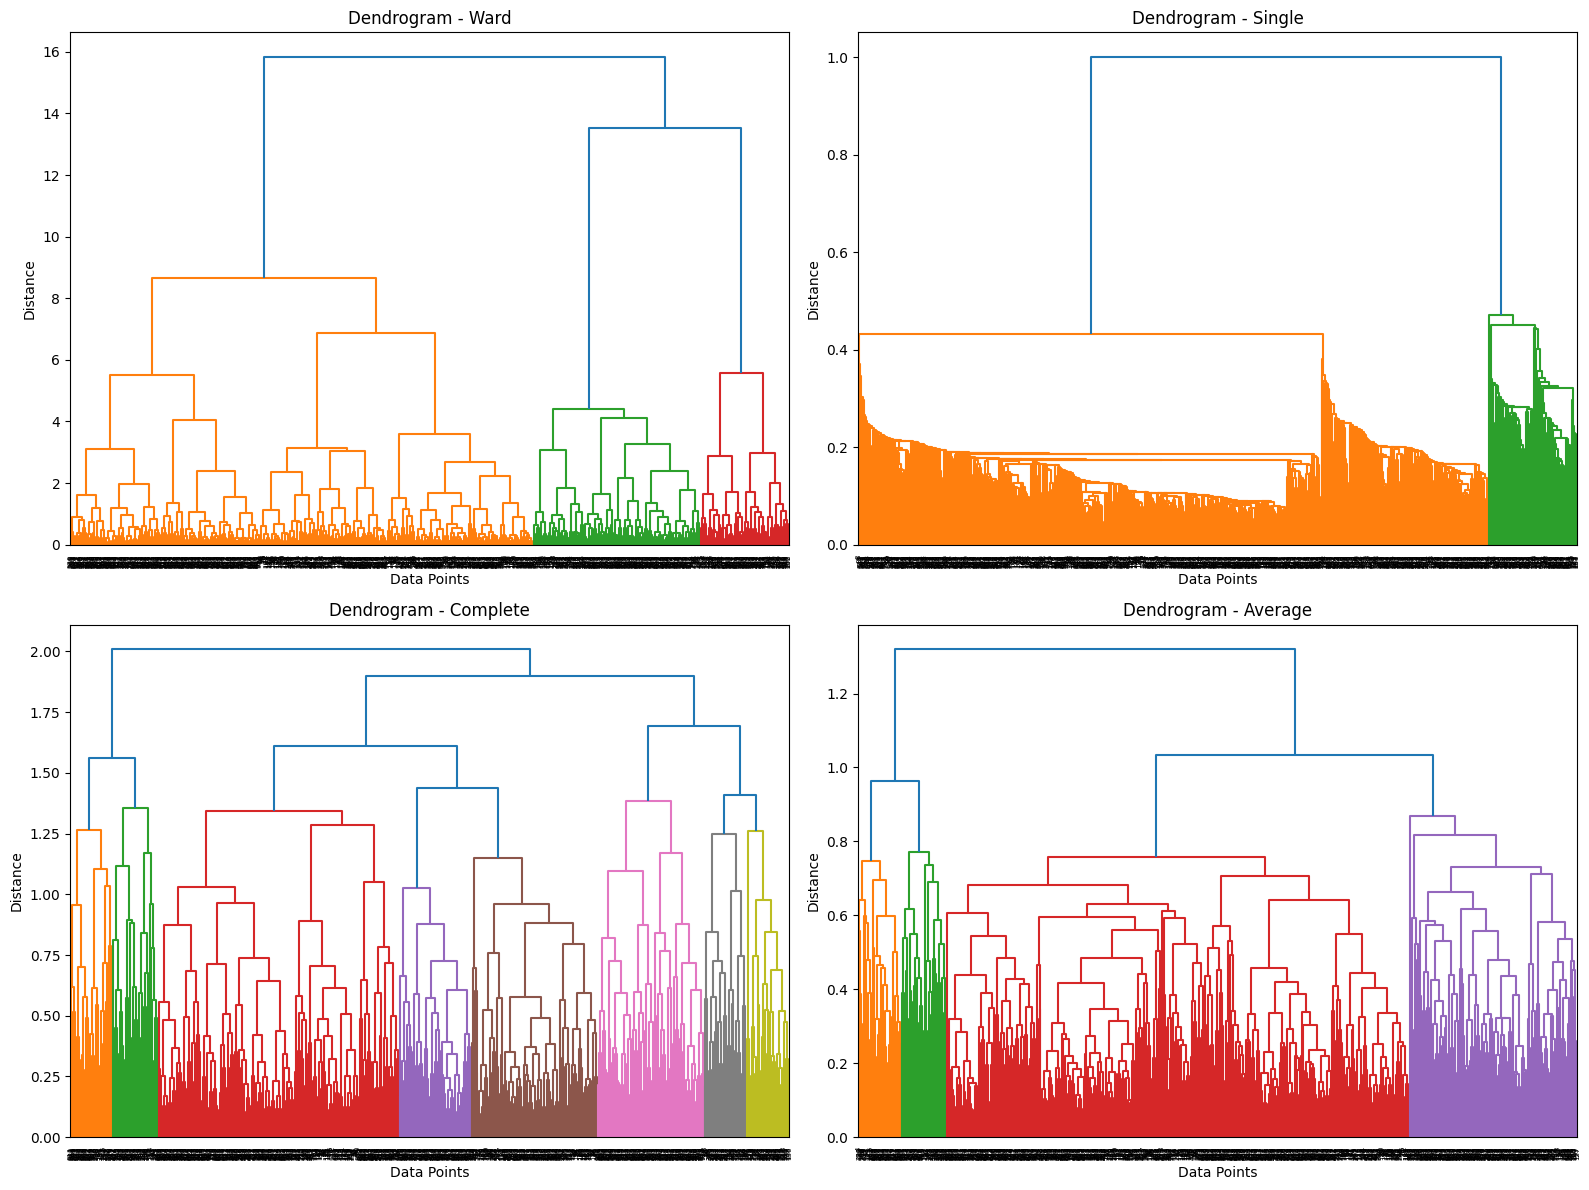

In [176]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# hitung linkage untuk semua metode
linked_ward = linkage(customer_scaled, method='ward')
linked_single = linkage(customer_scaled, method='single')
linked_complete = linkage(customer_scaled, method='complete')
linked_average = linkage(customer_scaled, method='average')

# plot 4 dendrogram
plt.figure(figsize=(16, 12))

# WARD
plt.subplot(2, 2, 1)
dendrogram(linked_ward)
plt.title("Dendrogram - Ward")
plt.xlabel("Data Points")
plt.ylabel("Distance")

# SINGLE
plt.subplot(2, 2, 2)
dendrogram(linked_single)
plt.title("Dendrogram - Single")
plt.xlabel("Data Points")
plt.ylabel("Distance")

# COMPLETE
plt.subplot(2, 2, 3)
dendrogram(linked_complete)
plt.title("Dendrogram - Complete")
plt.xlabel("Data Points")
plt.ylabel("Distance")

# AVERAGE
plt.subplot(2, 2, 4)
dendrogram(linked_average)
plt.title("Dendrogram - Average")
plt.xlabel("Data Points")
plt.ylabel("Distance")

plt.tight_layout()
plt.show()


#Validasi cluster (Silhouette Coefficient)

Tahap terakhir adalah mengevaluasi kualitas cluster menggunakan Silhouette Coefficient.
Nilai ini mengukur seberapa dekat suatu data ke cluster-nya sendiri dibandingkan dengan cluster lain. Setiap kombinasi metode linkage dan metrik jarak diuji, lalu hasilnya disimpan dalam tabel.

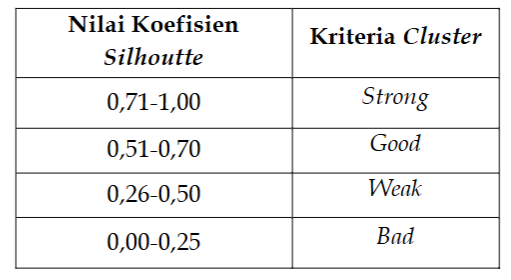

In [177]:
# --- Pastikan data sudah di-scale ---
X = customer_scaled

# --- Daftar metode linkage dan jarak yang diuji ---
linkage_methods = ["single", "complete", "average", "ward"]
distance_metrics = ["euclidean", "cityblock", "canberra"]

# --- Hasil disimpan di DataFrame ---
results = []

for linkage in linkage_methods:
    row = {"Metode": linkage.title() + " Linkage"}
    for metric in distance_metrics:
        # Ward hanya bisa pakai Euclidean
        if linkage == "ward" and metric != "euclidean":
            row[f"Jarak {metric.title()}"] = "-"
            continue
        model = AgglomerativeClustering(n_clusters=5, linkage=linkage, metric=metric)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels, metric=metric)
        row[f"Jarak {metric.title()}"] = round(score, 2)
    results.append(row)

# --- Buat tabel hasil ---
tabel_validasi = pd.DataFrame(results)
tabel_validasi.rename(columns={
    "Jarak Euclidean": "Jarak Euclidean",
    "Jarak Cityblock": "Jarak Manhattan",
    "Jarak Canberra": "Jarak Canberra"
}, inplace=True)

print("=== TABEL VALIDASI CLUSTER (Silhouette Coefficient) ===")
display(tabel_validasi)

=== TABEL VALIDASI CLUSTER (Silhouette Coefficient) ===


,Metode,Jarak Euclidean,Jarak Manhattan,Jarak Canberra
0,Single Linkage,0.30,0.3,0.17
1,Complete Linkage,0.22,0.21,0.31
2,Average Linkage,0.31,0.35,0.29
3,Ward Linkage,0.24,-,-


Dari hasil ini, Average Linkage dengan jarak Canberra (0.37) menghasilkan kualitas pengelompokan terbaik,
karena cluster yang terbentuk paling kompak di dalam dan paling terpisah antar kelompok.

# Selesai